In [62]:
# https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?select=anime.csv

In [6]:
import pandas as pd
import scipy.sparse as sp
import random
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
import numpy as np

In [23]:
anime_df = pd.read_csv('anime.csv')

In [24]:
rating_df = pd.read_csv('rating.csv')
print(rating_df.head())

   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1


In [31]:
subset_size = 100000
subset_indices = np.random.choice(len(rating_df), subset_size, replace=False)
subset_rating_df = rating_df.iloc[subset_indices]
merged_df = pd.merge(subset_rating_df, anime_df, on='anime_id')
user_anime_matrix = merged_df.pivot_table(index='user_id', columns='name', values='rating_x', fill_value=0)
user_anime_matrix = user_anime_matrix.ffill(axis=1)
print(user_anime_matrix.head())

name     &quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi  \
user_id                                                        
1                                                        0     
5                                                        0     
7                                                        0     
14                                                       0     
17                                                       0     

name     &quot;Bungaku Shoujo&quot; Memoire  &quot;Bungaku Shoujo&quot; Movie  \
user_id                                                                         
1                                         0                                 0   
5                                         0                                 0   
7                                         0                                 0   
14                                        0                                 0   
17                                        0                      

In [32]:
# (a) Top 3 anime by the number of users who rated them
top_anime_by_users = user_anime_matrix.sum().sort_values(ascending=False).head(3)
anime_df_reset = anime_df.reset_index()
anime_indices = anime_df_reset[anime_df_reset['name'].isin(top_anime_by_users.index)].index.tolist()
top_anime_titles = anime_df_reset.loc[anime_indices, 'name']
print("Top 3 Anime by Number of User ratings:")
for title, count in zip(top_anime_titles, top_anime_by_users):
    print(f"{title}: {count} user ratings")

Top 3 Anime by Number of User ratings:
Code Geass: Hangyaku no Lelouch: 3880 user ratings
Death Note: 2873 user ratings
Shingeki no Kyojin: 2765 user ratings


In [35]:
# (b) Top 3 users by the number of animes they have rated
top_users_by_anime = user_anime_matrix.sum(axis=1).sort_values(ascending=False).head(3)
print("\nTop 3 Users by Number of Anime Rated:")
for user_id, count in zip(top_users_by_anime.index, top_users_by_anime):
    print(f"User ID {user_id}: {count} anime")


Top 3 Users by Number of Anime Rated:
User ID 42635: 330 anime
User ID 51270: 292 anime
User ID 57620: 270 anime


/Users/sumantanantha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sumantanantha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sumantanantha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sumantanantha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default valu

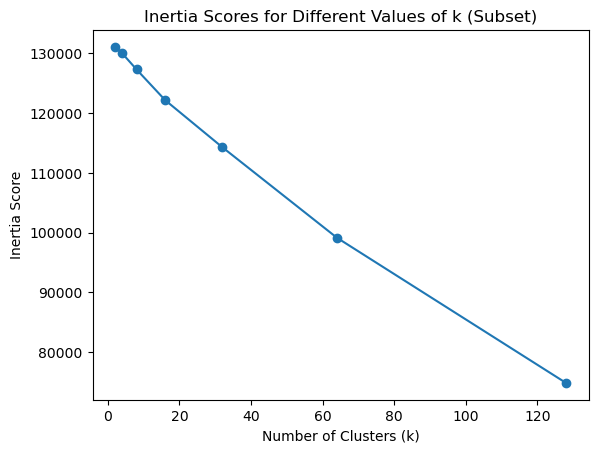

In [36]:
subset_size = 1000  
subset_indices = np.random.choice(len(user_anime_matrix), subset_size, replace=False)
subset_data = user_anime_matrix.iloc[subset_indices]

inertia_scores = []
k_values = [2, 4, 8, 16, 32, 64, 128]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(subset_data)
    inertia_scores.append(kmeans.inertia_)

plt.plot(k_values, inertia_scores, marker='o')
plt.title('Inertia Scores for Different Values of k (Subset)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia Score')
plt.show()

In [37]:
# from the graph the elbow point would be k=16 which shows the graph begining to gradually slow down after that.

In [39]:
chosen_k = 16
kmeans_chosen = KMeans(n_clusters=chosen_k, random_state=42)
user_anime_matrix['cluster'] = kmeans_chosen.fit_predict(user_anime_matrix)
top_anime_per_cluster = user_anime_matrix.groupby('cluster').mean().T

# Reset the index of top_anime_per_cluster
top_anime_per_cluster_reset = top_anime_per_cluster.reset_index()

print("\nTop Three Anime per Cluster:")
for cluster in range(chosen_k):
    top_anime_cluster = top_anime_per_cluster_reset[cluster].sort_values(ascending=False).head(3)
    top_anime_titles_cluster = anime_df_reset.loc[top_anime_cluster.index, 'name']

    print(f"\nCluster {cluster + 1}:")
    for title, avg_rating in zip(top_anime_titles_cluster, top_anime_cluster):
        print(f"{title}: Average Rating {avg_rating:.2f}")

/Users/sumantanantha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Top Three Anime per Cluster:

Cluster 1:
Rokka no Yuusha Picture Drama: Average Rating 0.08
Servant x Service: Average Rating 0.07
Tenchi Muyou!: Average Rating 0.07

Cluster 2:
Aria The Animation: Average Rating 9.00
Lupin III: Part III: Average Rating 9.00
Little Lulu to Chicchai Nakama: Average Rating 9.00

Cluster 3:
Neo Angelique Abyss: Second Age: Average Rating 8.65
Peace Maker Kurogane Special: Average Rating 0.21
Shin Koihime†Musou: Otome Tairan OVA: Average Rating 0.21

Cluster 4:
Gun x Sword: Average Rating 7.86
Ganbare Genki: Average Rating 0.17
Koi Kaze: Average Rating 0.16

Cluster 5:
Bronze: Kouji Nanjo Cathexis: Average Rating 1.82
Gekkan Shoujo Nozaki-kun: Average Rating 1.31
Utawarerumono OVA Picture Drama: Average Rating 1.26

Cluster 6:
Crayon Shin-chan Movie 08: Arashi wo Yobu Jungle: Average Rating 4.36
Kuroko no Basket 2nd Season NG-shuu: Average Rating 3.99
Code:Breaker OVA: Average Rating 0.17

Cluster 7:
Sasuga no Sarutobi: Average Rating 8.46
Saki Achiga-hen

In [40]:
transposed_matrix = user_anime_matrix.T
mean_centered_matrix = transposed_matrix - transposed_matrix.mean(axis=0)
print("Mean-Centered Transposed Matrix:")
print(mean_centered_matrix.head())

Mean-Centered Transposed Matrix:
user_id                                                1         5      \
name                                                                     
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hats...  0.000345 -0.003109   
&quot;Bungaku Shoujo&quot; Memoire                  0.000345 -0.003109   
&quot;Bungaku Shoujo&quot; Movie                    0.000345 -0.003109   
.hack//G.U. Returner                                0.000345 -0.003109   
.hack//G.U. Trilogy                                 0.000345 -0.003109   

user_id                                                7         14     \
name                                                                     
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hats... -0.002591 -0.002073   
&quot;Bungaku Shoujo&quot; Memoire                 -0.002591 -0.002073   
&quot;Bungaku Shoujo&quot; Movie                   -0.002591 -0.002073   
.hack//G.U. Returner                               -0.002591 -0.002073   
.hac

In [41]:
k_components = 2
pca = PCA(n_components=k_components)
pca_result = pca.fit_transform(mean_centered_matrix)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
print("\nPCA Result:")
print(pca_df.head())


PCA Result:
        PC1       PC2
0 -0.302751  0.061533
1 -0.297577  0.017829
2 -0.301649  0.040960
3 -0.171778 -0.020446
4 -0.229802  0.044387


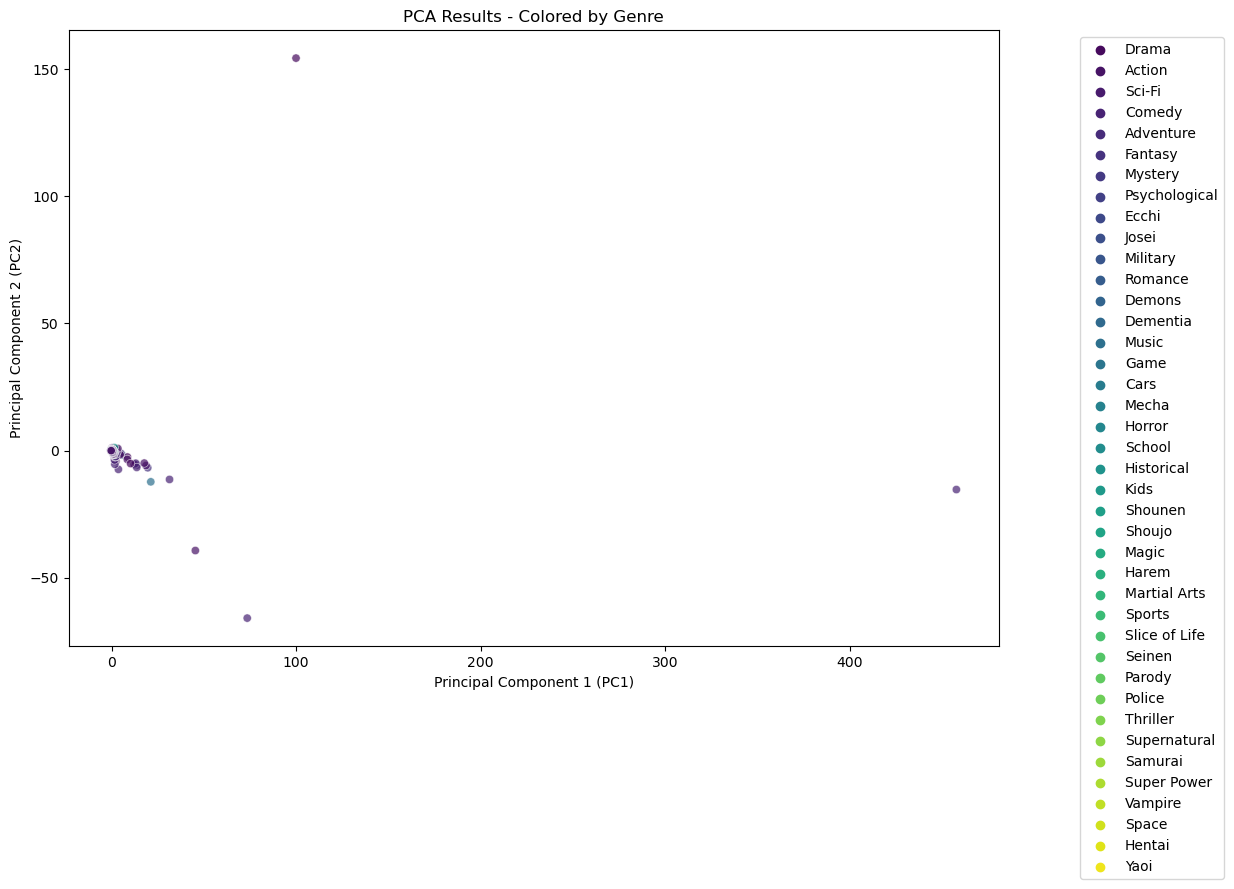

In [48]:
first_genre = anime_df['genre'].str.split(',').str[0]
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(x='PC1', y='PC2', hue=first_genre, data=pca_df, palette='viridis', alpha=0.7)
scatter_plot.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.title('PCA Results - Colored by Genre')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.show()

In [56]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()
components_80_percent = (cumulative_variance_ratio <= 0.80).sum() + 1
components_40_percent = (cumulative_variance_ratio <= 0.40).sum() + 1
print(f"Number of components needed to explain 80% of the variance: {components_80_percent}")
print(f"Number of components needed to explain 40% of the variance: {components_40_percent}")

Number of components needed to explain 80% of the variance: 3
Number of components needed to explain 40% of the variance: 3


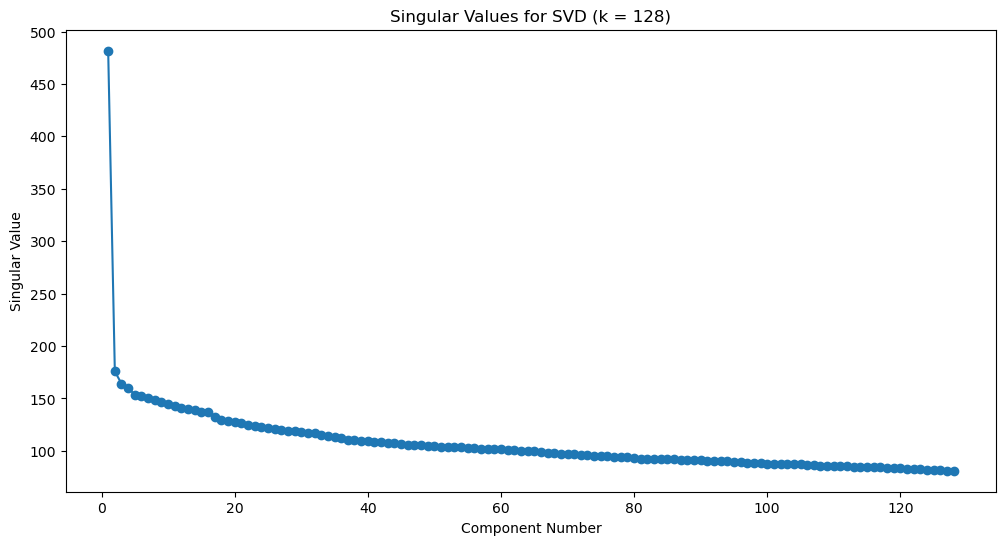

In [57]:
k_svd = 128
svd = TruncatedSVD(n_components=k_svd, random_state=42)
svd.fit(user_anime_matrix)
plt.figure(figsize=(12, 6))
plt.plot(range(1, k_svd + 1), svd.singular_values_, marker='o')
plt.title('Singular Values for SVD (k = 128)')
plt.xlabel('Component Number')
plt.ylabel('Singular Value')
plt.show()

In [58]:
k_values = [2, 4, 8, 16, 32, 64, 128]
explained_var_ratios = []

for k in k_values:
    svd_k = TruncatedSVD(n_components=k, random_state=42)
    svd_k.fit(user_anime_matrix)
    explained_var_ratios.append(svd_k.explained_variance_ratio_.sum())

for k, explained_var in zip(k_values, explained_var_ratios):
    print(f'k = {k}: Explained Variance Ratio = {explained_var:.4f}')

k = 2: Explained Variance Ratio = 0.0459
k = 4: Explained Variance Ratio = 0.0550
k = 8: Explained Variance Ratio = 0.0720
k = 16: Explained Variance Ratio = 0.1014
k = 32: Explained Variance Ratio = 0.1459
k = 64: Explained Variance Ratio = 0.2124
k = 128: Explained Variance Ratio = 0.3104


In [61]:
chosen_k_svd = 2
svd_chosen = TruncatedSVD(n_components=chosen_k_svd, random_state=42)
user_anime_svd = svd_chosen.fit_transform(user_anime_matrix)
user_anime_svd

array([[-1.34533469e-03,  1.68097414e-03],
       [ 4.96926505e-02, -5.12359627e-02],
       [ 1.63379708e-02, -3.16481328e-02],
       ...,
       [ 3.87173610e+00, -3.91707929e-01],
       [ 1.80236816e-02, -3.15183147e-02],
       [-9.44614991e-05,  6.79642898e-04]])

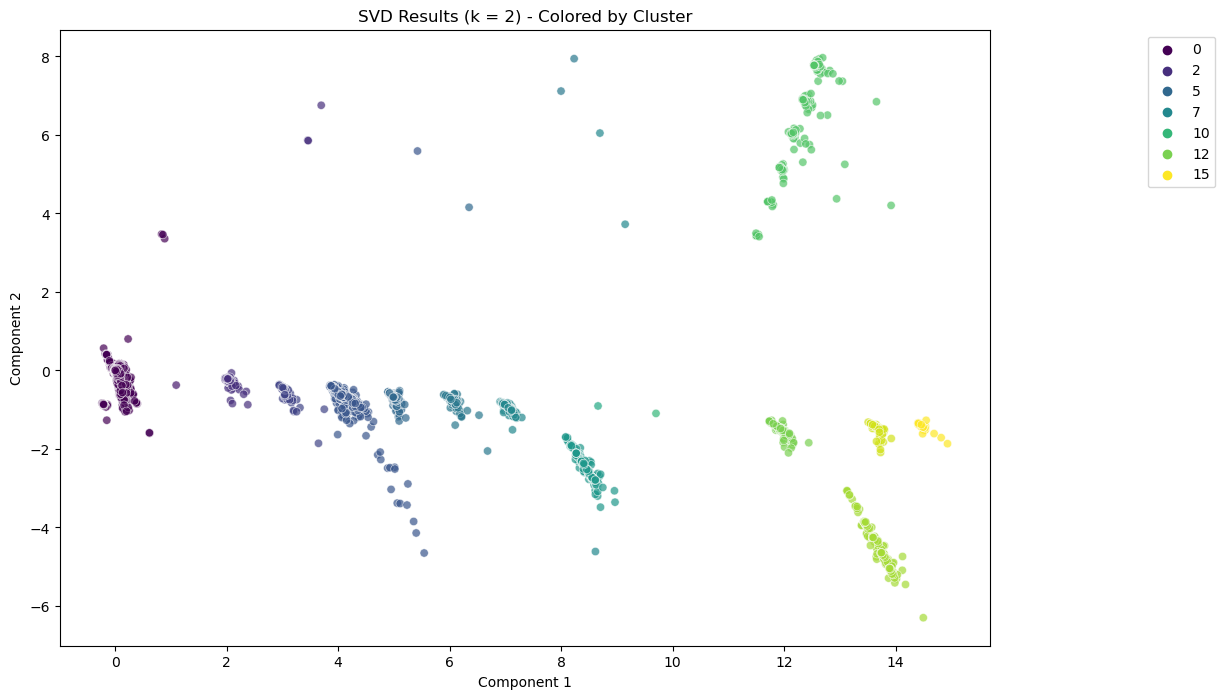

In [60]:
plt.figure(figsize=(12, 8))
scatter_plot_svd = sns.scatterplot(x=user_anime_svd[:, 0], y=user_anime_svd[:, 1], hue=user_anime_matrix['cluster'], palette='viridis', alpha=0.7)
scatter_plot_svd.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.title('SVD Results (k = 2) - Colored by Cluster')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()